<a href="https://colab.research.google.com/github/prakritipaul/mhcglobe/blob/main/prakriti_MHCglobe_code_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Checking if my implementation that draws upon Eric's individual functions is correct

Current implementation: v1_troubleshoot_MHCGlobe_pipeline

**In addition to below:**
I just wanted to test this on Eric's full model.  
It does very poorly compared to the other methods!


#### 3 Coding Methods:

(1) "My Code"
1. Load all individual models
2. Train all of them on the entire database (just check that example data is not in here- I see there is overlap!!)
3. Predict each one on 100 random HLA samples
4. Take the average

(2) "Ensemble Wrapper"   
Made a wrapper of Eric's retraining tutorial code.

(3) "Raw code cells"   
As above

Expected (1) to line up with (2) and (3), but in reality they are all different!
Done for human_pMHC_data_test = human_pMHC_data.sample(n=100, random_state=428364)

In [1]:
!git clone https://github.com/prakritipaul/mhcglobe.git

Cloning into 'mhcglobe'...
remote: Enumerating objects: 741, done.
remote: Counting objects: 100% (192/192), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 741 (delta 112), reused 72 (delta 28), pack-reused 549
Receiving objects: 100% (741/741), 112.81 MiB | 20.42 MiB/s, done.
Resolving deltas: 100% (410/410), done.
Updating files: 100% (199/199), done.
Error downloading object: data/distB62_unique_pseudpsequences.pkl (d151a08): Smudge error: Error downloading data/distB62_unique_pseudpsequences.pkl (d151a0800777499690d258210735bbe1bf8f627fedc59b579281582b6a03b3da): batch response: This repository is over its data quota. Account responsible for LFS bandwidth should purchase more data packs to restore access.

Errors logged to /content/mhcglobe/.git/lfs/logs/20240329T161615.961028399.log
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-process' failed
fatal: data/distB62_unique_pseudpsequences.pkl: smudge filter lfs failed
You can i

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import joblib as jb

import sys
sys.path.append("/content/mhcglobe/src")
import mhcglobe
import train_functions as trainf
import binding_affinity as ba
import sequence_functions as seqf
import prakriti_helper_functions as phf

# Mount google drive
# from google.colab import drive
# drive.mount('/content/drive')

### Get data
Contains both BA+EL, human and non-human

In [11]:
import mhc_data
# 729,538/1,229,838
pMHC = mhc_data.pMHC_Data(only_EL=False, drop_duplicate_records=True)
pMHC_data = pMHC.data
# pMHC_data.shape

### **Try saving this with joblib**

In [4]:
pMHC_data = phf.save_model(pMHC_data, "/content/drive/MyDrive/Colab Notebooks/MHCglobe/saved_objects/pMHC_data.joblib")

In [6]:
reloaded_pMHC_data = jb.load("/content/drive/MyDrive/Colab Notebooks/MHCglobe/saved_objects/pMHC_data.joblib")

In [8]:
reloaded_pMHC_data

,allele,dataset,measurement_inequality,measurement_type,measurement_value,peptide,Gene,is_ABC,is_human
0,HLA-A*03:01,IEDB,=,BA,340.633333,EVMPVSMAK,HLA-A,True,True
1,HLA-A*11:01,IEDB,=,BA,17.140000,EVMPVSMAK,HLA-A,True,True
2,HLA-A*03:01,IEDB,=,BA,219.816667,KTFPPTEPK,HLA-A,True,True
3,HLA-A*11:01,IEDB,=,BA,222.213333,KTFPPTEPK,HLA-A,True,True
4,HLA-A*03:01,IEDB,=,BA,57.250000,RLYYDSMSY,HLA-A,True,True
...,...,...,...,...,...,...,...,...,...
1229823,HLA-B*44:02,MHCFlury2_S1,<,MA,100.000000,AETEKQVAL,HLA-B,True,True
1229825,HLA-A*02:01,MHCFlury2_S1,<,MA,100.000000,NIFIGIVGV,HLA-A,True,True
1229831,HLA-A*02:01,MHCFlury2_S1,<,MA,100.000000,SMMKNFFFV,HLA-A,True,True
1229834,HLA-B*44:02,MHCFlury2_S1,<,MA,100.000000,EEQRAQQQL,HLA-B,True,True


#### Randomly pick 100 HLA-peptide peptide + Remove them from training data
These will be the test set, and is the same number of examples as in Eric's example df.   
**We want to balance the measurement inequality types in the test set**

In [12]:
# 678024
# Note: ba = 89529 (13%), sa/ma = 588495 (87%)
human_pMHC_data = pMHC_data[pMHC_data["allele"].str.contains("HLA")]
# 12% ba's
human_pMHC_data_test = human_pMHC_data.sample(n=100, random_state=428364)

# Seeing what happens if I only have ='s
# human_pMHC_data_test = human_pMHC_data.iloc[:100]

# 729438
pMHC_data_train = pMHC_data[~pMHC_data.index.isin(human_pMHC_data_test.index)]

In [13]:
human_pMHC_data_test.head(10)

,allele,dataset,measurement_inequality,measurement_type,measurement_value,peptide,Gene,is_ABC,is_human
327215,HLA-A*02:06,IEDB,<,SA,100.0,RVVDYLTKL,HLA-A,True,True
230440,HLA-B*27:05,IEDB,<,SA,100.0,TRYQTFVNF,HLA-B,True,True
137377,HLA-A*02:12,S3_Only,>,BA,20000.0,AARHKHQVM,HLA-A,True,True
206466,HLA-B*07:02,IEDB,<,SA,100.0,IPRSILMTTF,HLA-B,True,True
660865,HLA-B*27:05,S3_Only,<,SA,100.0,SRVMDFFRR,HLA-B,True,True
295659,HLA-C*12:02,IEDB,<,SA,100.0,STDPRPASY,HLA-C,True,True
1202888,HLA-B*35:03,MHCFlury2_S1,<,MA,100.0,SPHGIASVL,HLA-B,True,True
430595,HLA-B*49:01,IEDB,<,SA,100.0,IEESGEHII,HLA-B,True,True
348254,HLA-A*36:01,IEDB,<,SA,100.0,SLAMEMVLTGDR,HLA-A,True,True
422649,HLA-B*35:07,IEDB,<,SA,100.0,MPFDFRRFDIY,HLA-B,True,True


#### Reset Indices to prevent any issues downstream

In [14]:
pMHC_data_train.head(10)

,allele,dataset,measurement_inequality,measurement_type,measurement_value,peptide,Gene,is_ABC,is_human
0,HLA-A*03:01,IEDB,=,BA,340.633333,EVMPVSMAK,HLA-A,True,True
1,HLA-A*11:01,IEDB,=,BA,17.140000,EVMPVSMAK,HLA-A,True,True
2,HLA-A*03:01,IEDB,=,BA,219.816667,KTFPPTEPK,HLA-A,True,True
3,HLA-A*11:01,IEDB,=,BA,222.213333,KTFPPTEPK,HLA-A,True,True
4,HLA-A*03:01,IEDB,=,BA,57.250000,RLYYDSMSY,HLA-A,True,True
5,HLA-A*11:01,IEDB,=,BA,237.025000,RLYYDSMSY,HLA-A,True,True
6,HLA-A*11:01,IEDB,=,BA,56.833333,AVLQSGFRK,HLA-A,True,True
7,HLA-A*03:01,IEDB,=,BA,2069.000000,KCYGVSATK,HLA-A,True,True
8,HLA-A*11:01,IEDB,=,BA,8375.750000,KCYGVSATK,HLA-A,True,True
9,HLA-A*03:01,IEDB,=,BA,188.033333,QLFKPLTKK,HLA-A,True,True


In [15]:
pMHC_data_train = pMHC_data_train.reset_index(drop=True)
human_pMHC_data_test = human_pMHC_data_test.reset_index(drop=True)

In [16]:
pMHC_data_train.head(10)

,allele,dataset,measurement_inequality,measurement_type,measurement_value,peptide,Gene,is_ABC,is_human
0,HLA-A*03:01,IEDB,=,BA,340.633333,EVMPVSMAK,HLA-A,True,True
1,HLA-A*11:01,IEDB,=,BA,17.140000,EVMPVSMAK,HLA-A,True,True
2,HLA-A*03:01,IEDB,=,BA,219.816667,KTFPPTEPK,HLA-A,True,True
3,HLA-A*11:01,IEDB,=,BA,222.213333,KTFPPTEPK,HLA-A,True,True
4,HLA-A*03:01,IEDB,=,BA,57.250000,RLYYDSMSY,HLA-A,True,True
5,HLA-A*11:01,IEDB,=,BA,237.025000,RLYYDSMSY,HLA-A,True,True
6,HLA-A*11:01,IEDB,=,BA,56.833333,AVLQSGFRK,HLA-A,True,True
7,HLA-A*03:01,IEDB,=,BA,2069.000000,KCYGVSATK,HLA-A,True,True
8,HLA-A*11:01,IEDB,=,BA,8375.750000,KCYGVSATK,HLA-A,True,True
9,HLA-A*03:01,IEDB,=,BA,188.033333,QLFKPLTKK,HLA-A,True,True


In [17]:
human_pMHC_data_test.head(10)

,allele,dataset,measurement_inequality,measurement_type,measurement_value,peptide,Gene,is_ABC,is_human
0,HLA-A*02:06,IEDB,<,SA,100.0,RVVDYLTKL,HLA-A,True,True
1,HLA-B*27:05,IEDB,<,SA,100.0,TRYQTFVNF,HLA-B,True,True
2,HLA-A*02:12,S3_Only,>,BA,20000.0,AARHKHQVM,HLA-A,True,True
3,HLA-B*07:02,IEDB,<,SA,100.0,IPRSILMTTF,HLA-B,True,True
4,HLA-B*27:05,S3_Only,<,SA,100.0,SRVMDFFRR,HLA-B,True,True
5,HLA-C*12:02,IEDB,<,SA,100.0,STDPRPASY,HLA-C,True,True
6,HLA-B*35:03,MHCFlury2_S1,<,MA,100.0,SPHGIASVL,HLA-B,True,True
7,HLA-B*49:01,IEDB,<,SA,100.0,IEESGEHII,HLA-B,True,True
8,HLA-A*36:01,IEDB,<,SA,100.0,SLAMEMVLTGDR,HLA-A,True,True
9,HLA-B*35:07,IEDB,<,SA,100.0,MPFDFRRFDIY,HLA-B,True,True


#### Get 4 relevant columns

In [18]:
pMHC_data_train = pMHC_data_train[["allele", "peptide", "measurement_inequality", "measurement_value"]]
human_pMHC_data_test = human_pMHC_data_test[["allele", "peptide", "measurement_inequality", "measurement_value"]]

In [19]:
pMHC_data_train.head(10)

,allele,peptide,measurement_inequality,measurement_value
0,HLA-A*03:01,EVMPVSMAK,=,340.633333
1,HLA-A*11:01,EVMPVSMAK,=,17.140000
2,HLA-A*03:01,KTFPPTEPK,=,219.816667
3,HLA-A*11:01,KTFPPTEPK,=,222.213333
4,HLA-A*03:01,RLYYDSMSY,=,57.250000
5,HLA-A*11:01,RLYYDSMSY,=,237.025000
6,HLA-A*11:01,AVLQSGFRK,=,56.833333
7,HLA-A*03:01,KCYGVSATK,=,2069.000000
8,HLA-A*11:01,KCYGVSATK,=,8375.750000
9,HLA-A*03:01,QLFKPLTKK,=,188.033333


In [20]:
human_pMHC_data_test.head(10)

,allele,peptide,measurement_inequality,measurement_value
0,HLA-A*02:06,RVVDYLTKL,<,100.0
1,HLA-B*27:05,TRYQTFVNF,<,100.0
2,HLA-A*02:12,AARHKHQVM,>,20000.0
3,HLA-B*07:02,IPRSILMTTF,<,100.0
4,HLA-B*27:05,SRVMDFFRR,<,100.0
5,HLA-C*12:02,STDPRPASY,<,100.0
6,HLA-B*35:03,SPHGIASVL,<,100.0
7,HLA-B*49:01,IEESGEHII,<,100.0
8,HLA-A*36:01,SLAMEMVLTGDR,<,100.0
9,HLA-B*35:07,MPFDFRRFDIY,<,100.0


### Predict using Eric's full model

In [21]:
# Load MHCGlobe class object containing the fully trained model.
mhcglobe_model = mhcglobe.ensemble(train_type='full')

# Predict peptide-MHC binding with MHCGlobe
full_model_predictions = mhcglobe_model.predict_on_dataframe(human_pMHC_data_test)

In [22]:
full_model_predictions

,allele,peptide,measurement_inequality,measurement_value,mhcglobe_affinity,mhcglobe_score
0,HLA-A*02:06,RVVDYLTKL,<,100.0,101.526244,0.572975
1,HLA-B*27:05,TRYQTFVNF,<,100.0,131.878301,0.548800
2,HLA-A*02:12,AARHKHQVM,>,20000.0,34766.676807,0.033583
3,HLA-B*07:02,IPRSILMTTF,<,100.0,118.608037,0.558602
4,HLA-B*27:05,SRVMDFFRR,<,100.0,145.715486,0.539579
...,...,...,...,...,...,...
95,HLA-C*15:02,RIHDIAVQL,=,196.0,113.863410,0.562376
96,HLA-A*11:01,ALERLLSLKK,=,822.0,812.756943,0.380724
97,HLA-B*27:09,HRVSQDGLNL,<,100.0,122.631838,0.555519
98,HLA-B*57:03,SSSALVSSLHL,<,100.0,456.185245,0.434101


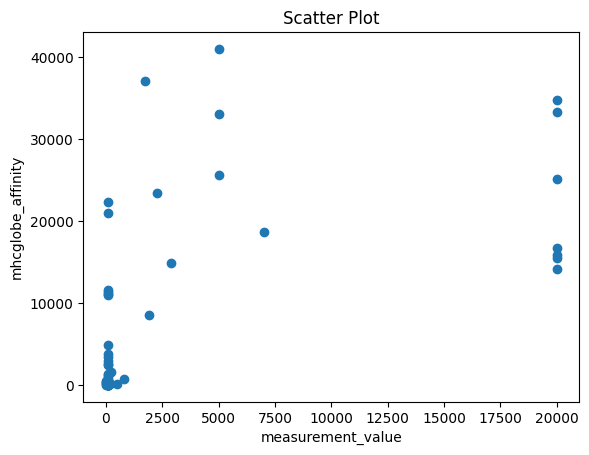

In [23]:
phf.make_scatter_plot(full_model_predictions, "measurement_value", "mhcglobe_affinity")

In [24]:
full_predictions_r, full_predictions_mse = phf.get_r_squared_mse(full_model_predictions, "measurement_value", "mhcglobe_affinity")
print("R-squared:", full_predictions_r)
print("MSE:", full_predictions_mse)

R-squared: 0.3914669201148852
MSE: 65475653.598376125


### Make X_tr, Y_tr, X_es, Y_es for training

In [25]:
# loads the init model
ensemble = mhcglobe.ensemble(train_type="init")
# DOES depend on init/full!
setup_data_training = ensemble.setup_data_training(pMHC_data_train)
# I don't think this is deterministic
X_tr, Y_tr, X_es, Y_es = setup_data_training

### Load base tensorflow models individually and train
Idea is that these trained models should be equivalent to full models that are loaded into the ensemble, and used for final predictions.

In [14]:
model_dir = "/content/mhcglobe/model/mhcglobe/init/"

model_1 = trainf.load_trained_mhcglobe_model(model_path=model_dir+"model14_fold13_ONE_HOT_init/")
model_2 = trainf.load_trained_mhcglobe_model(model_path=model_dir+"model37_fold15_ONE_HOT_init/")
model_3 = trainf.load_trained_mhcglobe_model(model_path=model_dir+"model79_fold9_ONE_HOT_init/")

In [15]:
new_model_path, verbose = "/content/mhcglobe/outputs", 0
init_model = model_1
new_model_1 = trainf.train_mhcglobe_model(init_model, X_tr, Y_tr, X_es, Y_es, new_model_path, verbose)

In [16]:
new_model_path, verbose = "/content/mhcglobe/outputs", 0
init_model = model_2
new_model_2 = trainf.train_mhcglobe_model(init_model, X_tr, Y_tr, X_es, Y_es, new_model_path, verbose)

In [17]:
new_model_path, verbose = "/content/mhcglobe/outputs", 0
init_model = model_3
new_model_3 = trainf.train_mhcglobe_model(init_model, X_tr, Y_tr, X_es, Y_es, new_model_path, verbose)

### Predict individually on example data

In [18]:
# prediction 1
to_predict = human_pMHC_data_test
X = seqf.get_XY(to_predict, encode_type="ONE_HOT", get_Y=False)


In [20]:
prediction_df_1 = get_prediction_df(new_model_1, X, to_predict)
prediction_df_1.head(10)

4/4 [==============================] - 0s 12ms/step


,allele,peptide,measurement_inequality,measurement_value,mhcglobe_affinities,mhcglobe_scores
0,HLA-A*02:06,RVVDYLTKL,<,100.0,136.114380,0.545878
1,HLA-B*27:05,TRYQTFVNF,<,100.0,120.417489,0.557203
2,HLA-A*02:12,AARHKHQVM,>,20000.0,15273.662183,0.109604
3,HLA-B*07:02,IPRSILMTTF,<,100.0,101.492399,0.573006
4,HLA-B*27:05,SRVMDFFRR,<,100.0,126.258258,0.552825
5,HLA-C*12:02,STDPRPASY,<,100.0,116.152507,0.560536
6,HLA-B*35:03,SPHGIASVL,<,100.0,105.722896,0.569231
7,HLA-B*49:01,IEESGEHII,<,100.0,107.112906,0.568024
8,HLA-A*36:01,SLAMEMVLTGDR,<,100.0,139.867728,0.543364
9,HLA-B*35:07,MPFDFRRFDIY,<,100.0,155.897480,0.533336


In [21]:
prediction_df_2 = get_prediction_df(new_model_2, X, to_predict)
prediction_df_2.head(10)

4/4 [==============================] - 0s 4ms/step


,allele,peptide,measurement_inequality,measurement_value,mhcglobe_affinities,mhcglobe_scores
0,HLA-A*02:06,RVVDYLTKL,<,100.0,92.874364,0.581207
1,HLA-B*27:05,TRYQTFVNF,<,100.0,98.355625,0.575907
2,HLA-A*02:12,AARHKHQVM,>,20000.0,47987.444920,0.003797
3,HLA-B*07:02,IPRSILMTTF,<,100.0,84.741608,0.589677
4,HLA-B*27:05,SRVMDFFRR,<,100.0,99.948888,0.574422
5,HLA-C*12:02,STDPRPASY,<,100.0,99.810142,0.574550
6,HLA-B*35:03,SPHGIASVL,<,100.0,94.949099,0.579165
7,HLA-B*49:01,IEESGEHII,<,100.0,102.511948,0.572082
8,HLA-A*36:01,SLAMEMVLTGDR,<,100.0,93.601814,0.580486
9,HLA-B*35:07,MPFDFRRFDIY,<,100.0,86.322571,0.587968


In [22]:
prediction_df_3 = get_prediction_df(new_model_3, X, to_predict)
prediction_df_3.head(10)

4/4 [==============================] - 0s 4ms/step


,allele,peptide,measurement_inequality,measurement_value,mhcglobe_affinities,mhcglobe_scores
0,HLA-A*02:06,RVVDYLTKL,<,100.0,109.593253,0.565908
1,HLA-B*27:05,TRYQTFVNF,<,100.0,102.942770,0.571694
2,HLA-A*02:12,AARHKHQVM,>,20000.0,47675.959504,0.004399
3,HLA-B*07:02,IPRSILMTTF,<,100.0,83.568799,0.590965
4,HLA-B*27:05,SRVMDFFRR,<,100.0,103.292434,0.571381
5,HLA-C*12:02,STDPRPASY,<,100.0,100.698950,0.573731
6,HLA-B*35:03,SPHGIASVL,<,100.0,96.154537,0.577999
7,HLA-B*49:01,IEESGEHII,<,100.0,98.166404,0.576085
8,HLA-A*36:01,SLAMEMVLTGDR,<,100.0,93.981491,0.580112
9,HLA-B*35:07,MPFDFRRFDIY,<,100.0,97.316392,0.576889


### Get average results

In [23]:
# Average mhcglobe_scores
mhcglobe_affinities_df1 = prediction_df_1['mhcglobe_affinities']
mhcglobe_affinities_df2 = prediction_df_2['mhcglobe_affinities']
mhcglobe_affinities_df3 = prediction_df_3['mhcglobe_affinities']

In [24]:
mhcglobe_affinities_df1.head(5)

0      136.114380
1      120.417489
2    15273.662183
3      101.492399
4      126.258258
Name: mhcglobe_affinities, dtype: float64

In [25]:
mhcglobe_affinities_df2.head(5)

0       92.874364
1       98.355625
2    47987.444920
3       84.741608
4       99.948888
Name: mhcglobe_affinities, dtype: float64

In [26]:
mhcglobe_affinities_df3.head(5)

0      109.593253
1      102.942770
2    47675.959504
3       83.568799
4      103.292434
Name: mhcglobe_affinities, dtype: float64

In [27]:
all_affinities = pd.concat([mhcglobe_affinities_df1, mhcglobe_affinities_df2, mhcglobe_affinities_df3], axis=1)
all_affinities.head(5)

,mhcglobe_affinities,mhcglobe_affinities,mhcglobe_affinities
0,136.114380,92.874364,109.593253
1,120.417489,98.355625,102.942770
2,15273.662183,47987.444920,47675.959504
3,101.492399,84.741608,83.568799
4,126.258258,99.948888,103.292434


In [28]:
average_mhcglobe_affinities = all_affinities.mean(axis=1)
average_mhcglobe_affinities.head(5)

0      112.860665
1      107.238628
2    36979.022202
3       89.934269
4      109.833193
dtype: float64

### Compare with true values

In [29]:
human_pMHC_data_test[["allele", "peptide", "measurement_inequality", "measurement_value"]].head(5)

,allele,peptide,measurement_inequality,measurement_value
0,HLA-A*02:06,RVVDYLTKL,<,100.0
1,HLA-B*27:05,TRYQTFVNF,<,100.0
2,HLA-A*02:12,AARHKHQVM,>,20000.0
3,HLA-B*07:02,IPRSILMTTF,<,100.0
4,HLA-B*27:05,SRVMDFFRR,<,100.0


In [30]:
prediction_df_comparison = human_pMHC_data_test[["allele", "peptide", "measurement_inequality", "measurement_value"]]
prediction_df_comparison["predicted_mhcglobe_affinities"] = average_mhcglobe_affinities
prediction_df_comparison

,allele,peptide,measurement_inequality,measurement_value,predicted_mhcglobe_affinities
0,HLA-A*02:06,RVVDYLTKL,<,100.0,112.860665
1,HLA-B*27:05,TRYQTFVNF,<,100.0,107.238628
2,HLA-A*02:12,AARHKHQVM,>,20000.0,36979.022202
3,HLA-B*07:02,IPRSILMTTF,<,100.0,89.934269
4,HLA-B*27:05,SRVMDFFRR,<,100.0,109.833193
...,...,...,...,...,...
95,HLA-C*15:02,RIHDIAVQL,=,196.0,107.046228
96,HLA-A*11:01,ALERLLSLKK,=,822.0,160.512745
97,HLA-B*27:09,HRVSQDGLNL,<,100.0,96.690563
98,HLA-B*57:03,SSSALVSSLHL,<,100.0,89.672296


### Plot + Get r^2

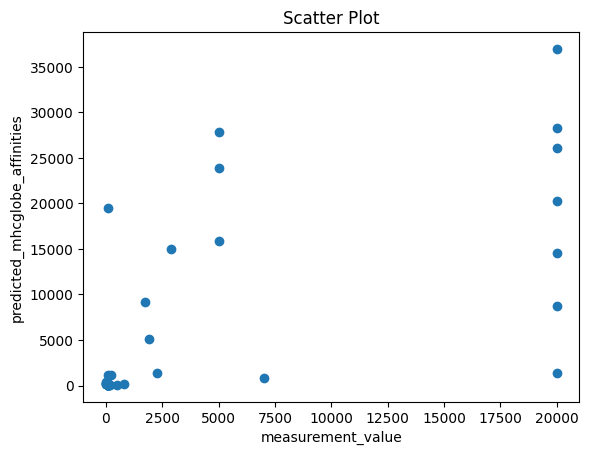

In [32]:
phf.make_scatter_plot(prediction_df_comparison, "measurement_value", "predicted_mhcglobe_affinities")

In [34]:
my_predictions_r, my_predictions_mse = phf.get_r_squared_mse(prediction_df_comparison, "measurement_value", "predicted_mhcglobe_affinities")
print("R-squared:", my_predictions_r)
print("MSE:", my_predictions_mse)

R-squared: 0.5240476284883292
MSE: 25291052.956852604


## What happens if I use his tutorial code?

### Wrapper Functions

In [36]:
# ~11 mins to run!
new_mhcglobe_path = "/content/mhcglobe/outputs/"
df_train, df_test, verbose = pMHC_data_train, human_pMHC_data_test, 0
ensemble_predictions = phf.get_ensemble_predictions(new_mhcglobe_path, df_train, df_test, verbose)

Training model 0
Training model 1
Training model 2
Predicting for model 0
Predicting for model 1
Predicting for model 2


In [38]:
ensemble_comparison_df = phf.make_comparison_df(ensemble_predictions, df_test)
ensemble_comparison_df

,allele,peptide,measurement_value,mhcglobe_affinity
0,HLA-A*02:06,RVVDYLTKL,100.0,97.406683
1,HLA-B*27:05,TRYQTFVNF,100.0,104.298312
2,HLA-A*02:12,AARHKHQVM,20000.0,29746.604709
3,HLA-B*07:02,IPRSILMTTF,100.0,83.346405
4,HLA-B*27:05,SRVMDFFRR,100.0,107.609412
...,...,...,...,...
95,HLA-C*15:02,RIHDIAVQL,196.0,105.960025
96,HLA-A*11:01,ALERLLSLKK,822.0,132.978473
97,HLA-B*27:09,HRVSQDGLNL,100.0,95.255023
98,HLA-B*57:03,SSSALVSSLHL,100.0,88.773074


### Plot and get r^2

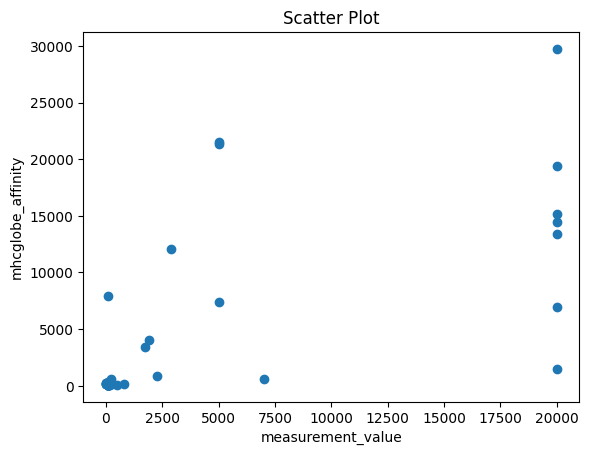

In [45]:
phf.make_scatter_plot(ensemble_comparison_df, "measurement_value", "mhcglobe_affinity")

In [46]:
eric_predictions_r, eric_predictions_mse = phf.get_r_squared_mse(ensemble_comparison_df, "measurement_value", "mhcglobe_affinity")
print("R-squared:", eric_predictions_r)
print("MSE:", eric_predictions_mse)

R-squared: 0.5358076967931116
MSE: 14509683.328813527


### Initial Raw Cells!

In [39]:
new_mhcglobe_path = "/content/mhcglobe/outputs/example_mhcglobe/"
eric_init_ensemble = mhcglobe.ensemble(train_type='init', new_mhcglobe_path=new_mhcglobe_path)

print(eric_init_ensemble.ensemble_base_models)
print(eric_init_ensemble.ensemble_model_paths)

[<keras.src.engine.functional.Functional object at 0x7acfe95c5180>, <keras.src.engine.functional.Functional object at 0x7acfe95b87f0>, <keras.src.engine.functional.Functional object at 0x7ad0d5316d70>]
['/content/mhcglobe/model/mhcglobe/init/model14_fold13_ONE_HOT_init', '/content/mhcglobe/model/mhcglobe/init/model37_fold15_ONE_HOT_init', '/content/mhcglobe/model/mhcglobe/init/model79_fold9_ONE_HOT_init']


### Train and save 3 models

In [43]:
df_train = pMHC_data_train
verbose = 0

new_model_list = list()
new_model_paths = mhcglobe.LoadMHCGlobe().new_model_paths(new_mhcglobe_path)
for init_model, new_model_path in zip(eric_init_ensemble.ensemble_base_models, new_model_paths):
            assert not os.path.exists(new_model_path), 'Already trained: {}'.format(new_model_path)

            # Data
            X_tr, Y_tr, X_es, Y_es = eric_init_ensemble.setup_data_training(df_train)

            # Train
            new_model = trainf.train_mhcglobe_model(init_model, X_tr, Y_tr, X_es, Y_es, new_model_path, verbose)

            # # Save them
            new_model_list.append(new_model)

# They are called _model14_fold13_ONE_HOT...

### Lines with issues

In [ ]:
# There's something wrong with this line (last line of .train_ensemble)
# ???
returned_ensemble = mhcglobe.ensemble(train_type=None, new_mhcglobe_path=new_mhcglobe_path)

In [ ]:
# Also doesn't work
user_mhcglobe = mhcglobe.ensemble(new_mhcglobe_path=new_model_path)

### So let's expand the individual functions
### The following are predictions

In [47]:
df_test = human_pMHC_data_test
# len 2; 2, 100
X = seqf.get_XY(df_test, encode_type=eric_init_ensemble.protein_encoding, get_Y=False)

In [48]:
# predictions = self.ensemble_predict(X)
ensemble_predictions_raw = pd.DataFrame()
# len=3; 3, 100
base_model_predictions = []
for model in new_model_list:
        predictions = pd.DataFrame(model.predict(X, verbose=0))
        base_model_predictions.append(predictions)
ensemble_predictions_raw = pd.concat(base_model_predictions, axis=1, ignore_index=True)
ensemble_predictions_raw.loc[:, 'mhcglobe_score'] = np.mean(ensemble_predictions_raw, axis=1)
ensemble_predictions_raw.loc[:, 'mhcglobe_affinity'] = list(map(ba.to_ic50, ensemble_predictions_raw['mhcglobe_score']))
ensemble_predictions_raw.columns = eric_init_ensemble.hparam_ids + ['mhcglobe_score', 'mhcglobe_affinity']

In [51]:
ensemble_predictions_raw.head(5)

,"(13, 14, ONE_HOT)","(15, 37, ONE_HOT)","(9, 79, ONE_HOT)",mhcglobe_score,mhcglobe_affinity
0,0.546207,0.586745,0.589848,0.574267,100.117136
1,0.559130,0.573774,0.572023,0.568309,106.783083
2,0.077922,0.003174,0.006919,0.029338,36400.727442
3,0.587393,0.582352,0.613859,0.594535,80.402558
4,0.556119,0.574372,0.568855,0.566449,108.954429


In [52]:
# pd.concat([df, predictions], axis=1)
ensemble_predictions_raw.index = df_test.index
eric_df_comparison = pd.concat([df_test, ensemble_predictions_raw], axis=1)
eric_df_comparison = eric_df_comparison.loc[:, ['allele', 'peptide', 'measurement_value', 'mhcglobe_affinity']]
eric_df_comparison.head(5)

,allele,peptide,measurement_value,mhcglobe_affinity
0,HLA-A*02:06,RVVDYLTKL,100.0,100.117136
1,HLA-B*27:05,TRYQTFVNF,100.0,106.783083
2,HLA-A*02:12,AARHKHQVM,20000.0,36400.727442
3,HLA-B*07:02,IPRSILMTTF,100.0,80.402558
4,HLA-B*27:05,SRVMDFFRR,100.0,108.954429


### Compare with me
Different :(

In [54]:
# From ensemble wrapper code
ensemble_comparison_df.head(5)

,allele,peptide,measurement_value,mhcglobe_affinity
0,HLA-A*02:06,RVVDYLTKL,100.0,97.406683
1,HLA-B*27:05,TRYQTFVNF,100.0,104.298312
2,HLA-A*02:12,AARHKHQVM,20000.0,29746.604709
3,HLA-B*07:02,IPRSILMTTF,100.0,83.346405
4,HLA-B*27:05,SRVMDFFRR,100.0,107.609412


In [55]:
# From individually trained then averaged
prediction_df_comparison.head(5)

,allele,peptide,measurement_inequality,measurement_value,predicted_mhcglobe_affinities
0,HLA-A*02:06,RVVDYLTKL,<,100.0,112.860665
1,HLA-B*27:05,TRYQTFVNF,<,100.0,107.238628
2,HLA-A*02:12,AARHKHQVM,>,20000.0,36979.022202
3,HLA-B*07:02,IPRSILMTTF,<,100.0,89.934269
4,HLA-B*27:05,SRVMDFFRR,<,100.0,109.833193


### Plot + Get r^2

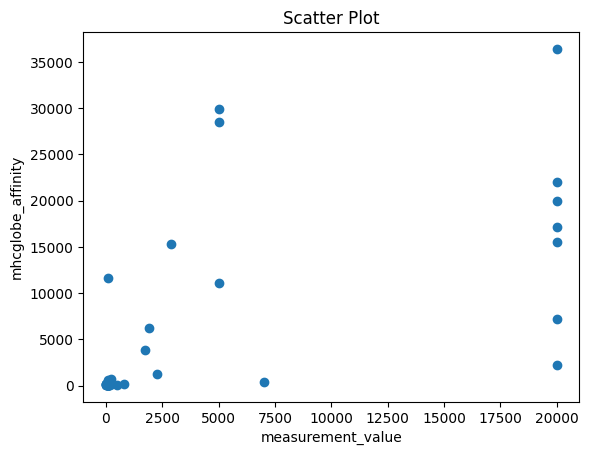

In [56]:
phf.make_scatter_plot(eric_df_comparison, "measurement_value", "mhcglobe_affinity")

In [57]:
eric_predictions_r, eric_predictions_mse = phf.get_r_squared_mse(eric_df_comparison, "measurement_value", "mhcglobe_affinity")
print("R-squared:", eric_predictions_r)
print("MSE:", eric_predictions_mse)

R-squared: 0.48894592081351823
MSE: 23427588.6978099
